# Coding Assignment 5

Group Members:
Zubair Lalani (zubairl2)
Adithya Swaminathan (adithya9)

## Setup

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from gap_statistic import OptimalK

## Problem 1


Read the data and one-hot encode Gender predictor

In [35]:
DATA_PATH = "data/problem1/Mall_Customers.csv"
df = pd.read_csv(DATA_PATH)
df = df.rename(columns={"Genre": "Gender"}) # Fix misspelling of the column name in the original data
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [36]:
df = pd.get_dummies(df, columns=["Gender"])
df["Gender_Female"] = df["Gender_Female"].astype(int)
df["Gender_Male"] = df["Gender_Male"].astype(int)
df.head()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male
0,1,19,15,39,0,1
1,2,21,15,81,0,1
2,3,20,16,6,1,0
3,4,23,16,77,1,0
4,5,31,17,40,1,0


In [37]:
df.dtypes

CustomerID                int64
Age                       int64
Annual Income (k$)        int64
Spending Score (1-100)    int64
Gender_Female             int64
Gender_Male               int64
dtype: object

Scale the features in our dataset and remove unnecessary columns

In [38]:
features_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)",
                "Gender_Female", "Gender_Male"]

X = df[features_cols] # removes CustomerID since we don't need it for our purposes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 1.A

Calculate optimal number of clusters use the Sillhoutte score

In [39]:
sil_scores = {}
k_values = range(2, 20)

for k in k_values:
    # setting n_init to avoid a warning
    # set random_state for reproducibility
    # try diff k for n_clusters and compare results using sillhoutte score
    kmeans = KMeans(n_clusters=k, random_state=598, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores[k] = score
    print(f"k = {k}, silhouette score = {score:.4f}")

# k with best silhouette
ksil = max(sil_scores, key=sil_scores.get)
print("Best k by silhouette:", ksil)

k = 2, silhouette score = 0.3964
k = 3, silhouette score = 0.3678
k = 4, silhouette score = 0.3322
k = 5, silhouette score = 0.3457
k = 6, silhouette score = 0.3621
k = 7, silhouette score = 0.3818
k = 8, silhouette score = 0.4016
k = 9, silhouette score = 0.4185
k = 10, silhouette score = 0.4378
k = 11, silhouette score = 0.4387
k = 12, silhouette score = 0.4336
k = 13, silhouette score = 0.4304
k = 14, silhouette score = 0.4373
k = 15, silhouette score = 0.4230
k = 16, silhouette score = 0.4269
k = 17, silhouette score = 0.4135
k = 18, silhouette score = 0.4198
k = 19, silhouette score = 0.4292
Best k by silhouette: 11


Use the following open source library to calculate the optimal number of clusters using the gap statistics:

https://github.com/milesgranger/gap_statistic

In [61]:
optimalK = OptimalK(n_jobs=1, parallel_backend="joblib", random_state=598)

# Try k from 1 to 10 (you can change the range)
kgap = optimalK(X_scaled, cluster_array=range(2,20))

print("Optimal k by Gap Statistic (kgap):", kgap)

Optimal k by Gap Statistic (kgap): 17


In [53]:
optimalK.gap_df

,n_clusters,gap_value,ref_dispersion_std,sk,gap*,sk*,diff,diff*
0,2.0,0.134789,27.941994,0.047688,86.860100,105.359271,0.102598,98.203498
1,3.0,0.070311,19.428163,0.038119,39.883238,51.226636,-0.152708,58.567372
2,4.0,0.256307,14.396660,0.033289,114.018833,132.702967,0.055081,128.825640
3,5.0,0.231704,11.594641,0.030477,90.171436,104.978243,0.130904,99.302488
4,6.0,0.132558,11.028140,0.031758,50.065470,59.196522,-0.034560,61.273019
5,7.0,0.202398,11.017282,0.035280,65.588062,76.795610,-0.109931,80.206802
6,8.0,0.328142,4.580044,0.015812,93.661680,108.280420,-0.133889,113.327275
7,9.0,0.495176,9.162757,0.033146,124.609307,144.274902,0.136271,140.111344
8,10.0,0.380260,5.767450,0.021354,98.953261,114.455298,-0.105031,117.836840
9,11.0,0.534388,11.983364,0.049097,117.516742,136.400321,0.051241,134.045975


In [41]:
kmeans_gap = KMeans(n_clusters=kgap, random_state=598, n_init=10)
df["cluster_gap"] = kmeans_gap.fit_predict(X_scaled)

# Silhouette k
kmeans_sil = KMeans(n_clusters=ksil, random_state=598, n_init=10)
df["cluster_sil"] = kmeans_sil.fit_predict(X_scaled)

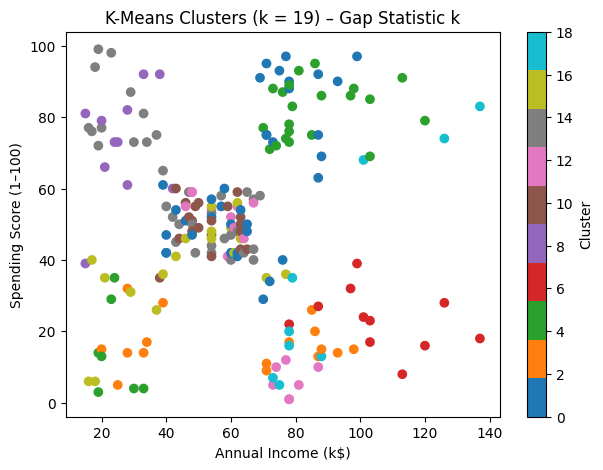

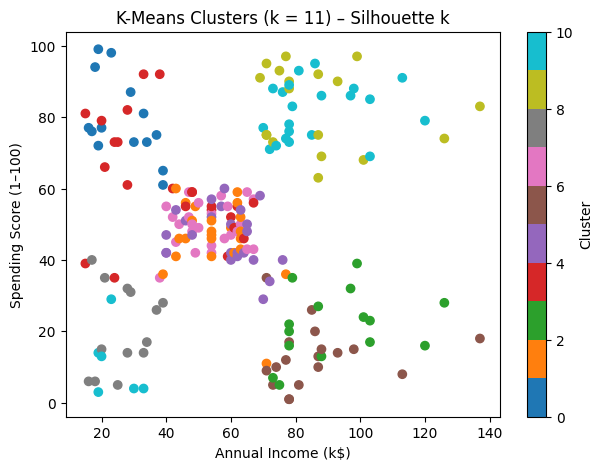

In [42]:
def plot_clusters(df, cluster_col, k, title_suffix):
    plt.figure(figsize=(7, 5))
    scatter = plt.scatter(
        df["Annual Income (k$)"],
        df["Spending Score (1-100)"],
        c=df[cluster_col],
        cmap="tab10"
    )
    plt.xlabel("Annual Income (k$)")
    plt.ylabel("Spending Score (1–100)")
    plt.title(f"K-Means Clusters (k = {k}) – {title_suffix}")
    plt.colorbar(scatter, label="Cluster")
    plt.show()

plot_clusters(df, "cluster_gap", kgap, "Gap Statistic k")
plot_clusters(df, "cluster_sil", ksil, "Silhouette k")

In [33]:
df[df["cluster_gap"] == 2]

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Gender_Female,Gender_Male,cluster_gap,cluster_sil
123,124,39,69,91,0,1,2,8
127,128,40,71,95,0,1,2,8
129,130,38,71,75,0,1,2,8
131,132,39,71,75,0,1,2,8
137,138,32,73,73,0,1,2,8
141,142,32,75,93,0,1,2,8
145,146,28,77,97,0,1,2,8
149,150,34,78,90,0,1,2,8
151,152,39,78,88,0,1,2,8
169,170,32,87,63,0,1,2,8


### 1.B

## Problem 2